In [47]:
import argparse, os, sys, glob
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms import ToPILImage, CenterCrop, Resize
from main import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

In [65]:
def transformer(img, is_mask, img_size=512):
    
    if is_mask:
        transform = Compose([Resize((img_size, img_size)),
                             ToTensor(),
                             Lambda(lambda t: t.to(torch.float32) / 255)
                             ])
    else:
        transform = Compose([Resize((img_size, img_size)),
                             ToTensor(),
                             Lambda(lambda t: t.to(torch.float32) / 255)
                             ])
    return transform(img)

In [101]:
def make_batch(image, mask, device):
    image = Image.open(image).convert('RGB')
    image = transformer(image, is_mask=None)
    image = image[None]
    print(image.shape)

    mask = Image.open(mask).convert('L')
    mask = transformer(mask, is_mask=True).squeeze()
    mask = mask[None,None]

    print(mask)

    masked_image = (1-mask)*image

    batch = {"image": image, "mask": mask, "masked_image": masked_image}
    '''
    for k in batch:
        batch[k] = batch[k].to(device=device)
        batch[k] = batch[k]*2.0-1.0
    '''
    return batch


In [106]:

def original_make_batch(image, mask, device):
    image = np.array(Image.open(image).convert("RGB"))
    image = image.astype(np.float32)/255.0
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)
    print(image.shape)

    mask = np.array(Image.open(mask).convert("L"))
    mask = mask.astype(np.float32)/255.0
    print(mask.shape)
    mask = mask[None,None]
    print(mask)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)
    print(mask, type(mask))

    masked_image = (1-mask)*image

    batch = {"image": image, "mask": mask, "masked_image": masked_image}
    for k in batch:
        batch[k] = batch[k].to(device=device)
        batch[k] = batch[k]*2.0-1.0
        
    return batch

In [5]:
img = 'samples/dog.jpg'
mask = 'samples/dog_mask.jpg'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([1, 3, 194, 259])
(194, 259)
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) <class 'torch.Tensor'>
torch.Size([1, 1, 194, 259])


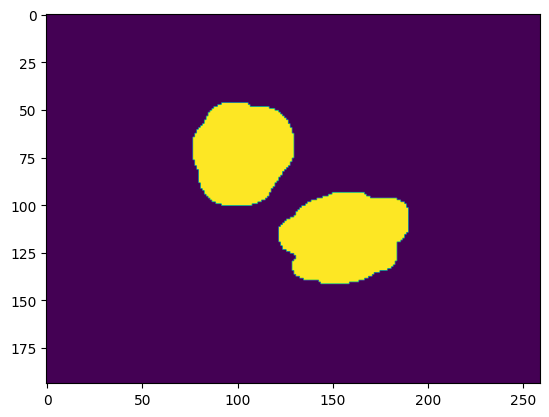

In [107]:

a = original_make_batch(img, mask, device)
print(a['mask'].shape)
plt.imshow(a['mask'][0][0])
plt.show()

torch.Size([1, 3, 512, 512])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


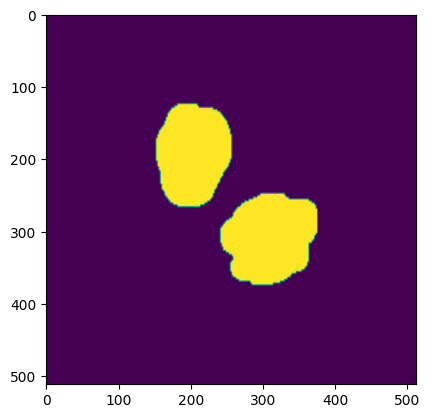

In [103]:
a = make_batch(img, mask, device)
plt.imshow(a['mask'][0][0])
plt.show()